## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all  the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('/home/soumya/edu/CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')
print(len(images))
# Step through the list and search for chessboard corners
gray = []
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)


img = cv2.imread('/home/soumya/edu/CarND-Advanced-Lane-Lines/camera_cal/calibration1.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

print (gray.shape)       
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
#print (ret, mtx, dist, rvecs, tvecs)
#img = cv2.imread('test_images/test1.jpg')

#dst = cv2.undistort(img, mtx, dist, None, mtx)



20
(720, 1280)


## And so on and so forth...

DDDDDDDD
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
calling region_of_interest
DDDDDDDDDDDDD
calling warper
(1280, 720)
[[  800.          417.6000061]
 [  400.          417.6000061]
 [  220.          720.       ]
 [ 1060.          720.       ]]
[[ 1060.     0.]
 [  220.     0.]
 [  220.   720.]
 [ 1060.   720.]]
(1280, 720)
[[  800.          417.6000061]
 [  400.          417.6000061]
 [  220.          720.       ]
 [ 1060.          720.       ]]
[[ 1060.     0.]
 [  220.     0.]
 [  220.   720.]
 [ 1060.   720.]]


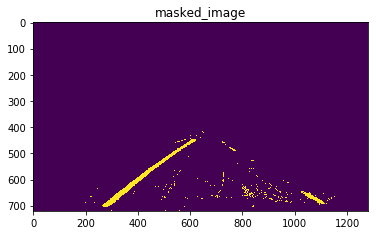

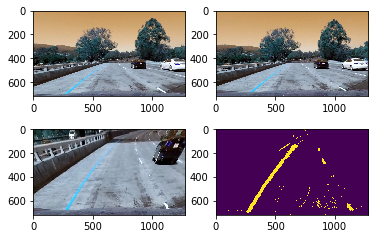

In [25]:
   %matplotlib inline
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    #plt.imshow(img)
    #plt.waitforbuttonpress()
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1],img.shape[0])

    print (img_size)
    print (src)
    print (dst)
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    return warped

def process_image(img):
    
    #printing out some stats and plotting
    print('This image is:', type(img), 'with dimensions:', img.shape)
    # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
    image = cv2.undistort(img, mtx, dist, None, mtx)

    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    thresh = (90, 255)
    s_binary = np.zeros_like(S)
    s_binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)    
    thresh_min = 20
    thresh_max = 100
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize = 3) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    #sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    # Calculate the gradient magnitude
    #gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    #scale_factor = np.max(gradmag)/255 
    #gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    #sgrad_binary = np.zeros_like(gradmag)
    
    #sgrad_binary[(gradmag >= thresh_min) & (gradmag <= thresh_max)] = 1
    
    
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    #mask your edges and 
    imshape = combined_binary.shape
    
    vertices = np.array([[(10,imshape[0]),(imshape[1]/2-10, imshape[0]*0.58),
                          (imshape[1]/2+10, imshape[0]*0.58), (imshape[1]-10,imshape[0])]], dtype=np.int32)
    print ("calling region_of_interest")
    masked_image = region_of_interest(combined_binary, vertices) 
    plt.imshow(masked_image)
    plt.title('masked_image')
   
    src_vertices = np.float32([
                    [800, imshape[0]*0.58], [400,imshape[0]*.58],
                    [220,imshape[0]],[imshape[1]-220, imshape[0]]])
   
    
    dst_vertices = np.float32([
                    [imshape[1]-220,0], [220,0],
                    [220,imshape[0]],[imshape[1]-220, imshape[0]]])
    '''
    dst_vertices = np.float32([
                    [imshape[1]-10, 0], [imshape[1]-10,imshape[0]],
                    [10,imshape[0]],[10, imshape[0]*0.3]])
'''
    print ('DDDDDDDDDDDDD')
    print ("calling warper")
    warped = warper(masked_image, src_vertices, dst_vertices)
    fig, axes = plt.subplots(2,2)
    #cv2.line(masked_image[
    #                [imshape[1]/2+10, imshape[0]*0.58], [imshape[1]-10,imshape[0]],
    #                [10,imshape[0]],[imshape[1]/2-10, imshape[0]*0.58]])

    axes[0,0].imshow(image)
    axes[0,1].imshow(img)

    axes[1,1].imshow(warped)
    warped = warper(img, src_vertices, dst_vertices)
    axes[1,0].imshow(warped)
    
'''    
    print('region of interest', vertices, type(masked_image), masked_image.shape)
    masked_image = np.expand_dims(masked_image, axis=0)
    outImage = weighted_img(masked_image, image)
    plt.imshow(outImage)
    plt.title('outImage')
    plt.waitforbuttonpress()
   '''
print ("DDDDDDDD")
img = cv2.imread('/home/soumya/edu/CarND-Advanced-Lane-Lines/test_images/test1.jpg')
process_image(img)

In [ ]:

'''white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
'''